# Waveform denoised and reconstructed

*author: Elena Cuoco*

**We want to show you how a gravitational wave signal becomes more apparent after whitening and double whitening of the data. 
The data are not downsampled** 

*Double whitening refers to the procedure applied in the time domain of data whitening, using the inverse of PSD. However, the method used in pytsa is based on the parametric estimation (AR) of the PSD and the Lattice Filter implementation in the time domain.*

In [1]:
import time
import os
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
from wdf.processes.Whitening import  *
from wdf.processes.DWhitening import  *

import logging, sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("info")

new_json_config_file = True    # set to True if you want to create new Configuration
if new_json_config_file==True:
    configuration = {
      "file": "./data/test.gwf",
      "channel": "H1:GWOSC-4KHZ_R1_STRAIN", 
      "len":1.0,
      "gps":1167559536,
      "outdir": "./",
      "dir":"./", 
      "ARorder": 3000,
      "learn": 300,
      "preWhite":4
    }

    filejson = os.path.join(os.getcwd(),"WavRec.json")
    file_json = open(filejson, "w+")
    json.dump(configuration, file_json)
    file_json.close()
logging.info("read parameters from JSON file")

par = Parameters()
filejson = "WavRec.json"
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.sampling))

whiten=Whitening(par.ARorder)  
par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)
par.LVfile ="./LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)

if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
    logging.info('Load AR parameters')
    whiten.ParametersLoad(par.ARfile, par.LVfile)
else:
    logging.info('Start AR parameter estimation')
    ######## read data for AR estimation###############
    strLearn = FrameIChannel(par.file, par.channel, par.learn, par.gps)
    Learn = SV()
    strLearn.GetData(Learn)   
    whiten.ParametersEstimate(Learn)
    whiten.ParametersSave(par.ARfile, par.LVfile)

INFO:root:read parameters from JSON file
INFO:root:channel= H1:GWOSC-4KHZ_R1_STRAIN at sampling frequency= 4096
INFO:root:Start AR parameter estimation


In [2]:
# sigma for the noise
par.sigma = whiten.GetSigma()
print('Estimated sigma= %s' % par.sigma)

Estimated sigma= 4.951028717156321e-22


We use some chunck of data to pre-heating the whitening procedure and avoiding the filter tail.

In [3]:
#Try to center 1sec beore and 1 after the event
lenS=2.0 
gpsEvent=1167559936.6
gps=gpsEvent-1.0-par.preWhite*lenS 
data = SV()
dataw = SV()
dataww = SV()
N=int(par.sampling*lenS)
streaming = FrameIChannel(par.file, par.channel, lenS, gps)
Dwhiten=DWhitening(whiten.LV ,N,0)

###---whitening preheating---###
for i in range(par.preWhite):
    streaming.GetData(data)
    whiten.Process(data, dataw)
    Dwhiten.Process(data, dataww)

In [4]:
print(par.file, par.channel, lenS, gps,dataw.GetStart())

./data/test.gwf H1:GWOSC-4KHZ_R1_STRAIN 2.0 1167559927.6 1167559933.6


In [5]:
streaming.GetData(data)
whiten.Process(data, dataw)
Dwhiten.Process(data, dataww)

In [6]:
print(dataw.GetStart(),dataw.GetY(0,0)) 

1167559935.6 5.647725652827097e-23


In [7]:
print(dataw.GetSize()/par.sampling)

2.0


## Plot: raw and whitened data

### time-domain

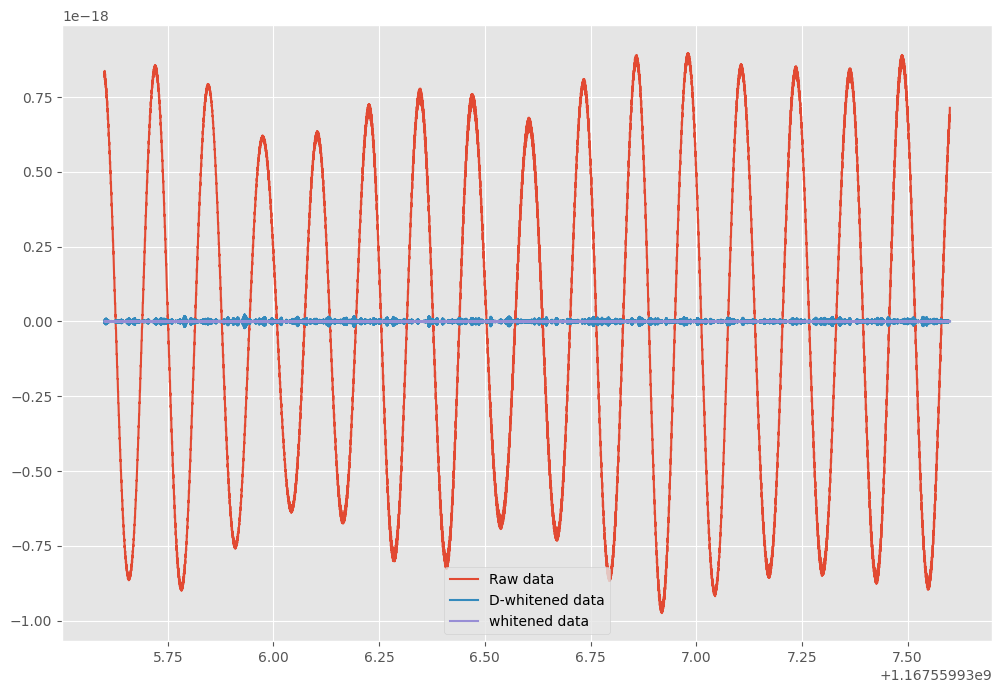

In [8]:
 
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab
import os
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)
x=np.zeros(data.GetSize())
y=np.zeros(data.GetSize())
yw=np.zeros(dataw.GetSize())
yww=np.zeros(dataww.GetSize())

for i in range(dataw.GetSize()):
    x[i]=data.GetX(i)
    y[i]=data.GetY(0,i)
    yw[i]=dataw.GetY(0,i)
    yww[i]=dataww.GetY(0,i)

fig, ax = plt.subplots()

ax.plot(x, y,  label='Raw data')
ax.plot(x, yww, label='D-whitened data')
ax.plot(x, yw, label='whitened data')

ax.legend()
plt.show()
    


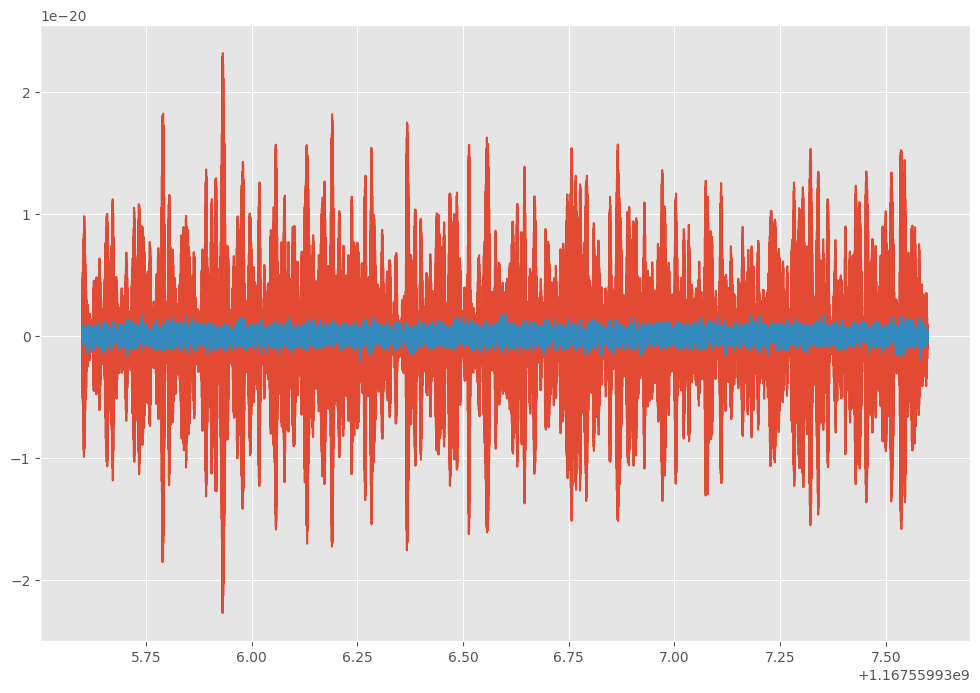

In [9]:
fig, ax = plt.subplots()
ax.plot(x, yww, label='D-whitened data')
ax.plot(x, yw, label='whitened data')
 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from matplotlib.colors import LogNorm

def prepareImage_gw(x,y,fs,title="title"):
    w = 10.
    freq = np.linspace(1, fs/2, int(fs/2))
    widths = w*fs / (2*freq*np.pi)
    z = np.abs(signal.cwt(y, signal.morlet2, widths, w=w))**2
    
    plt.pcolormesh(x, freq,z,cmap='Spectral',shading='gouraud',alpha=0.95,norm=LogNorm())
    plt.yscale('log')
    plt.ylim(10, 1000)
    plt.title(str(title))
    plt.show() 
   
    return 

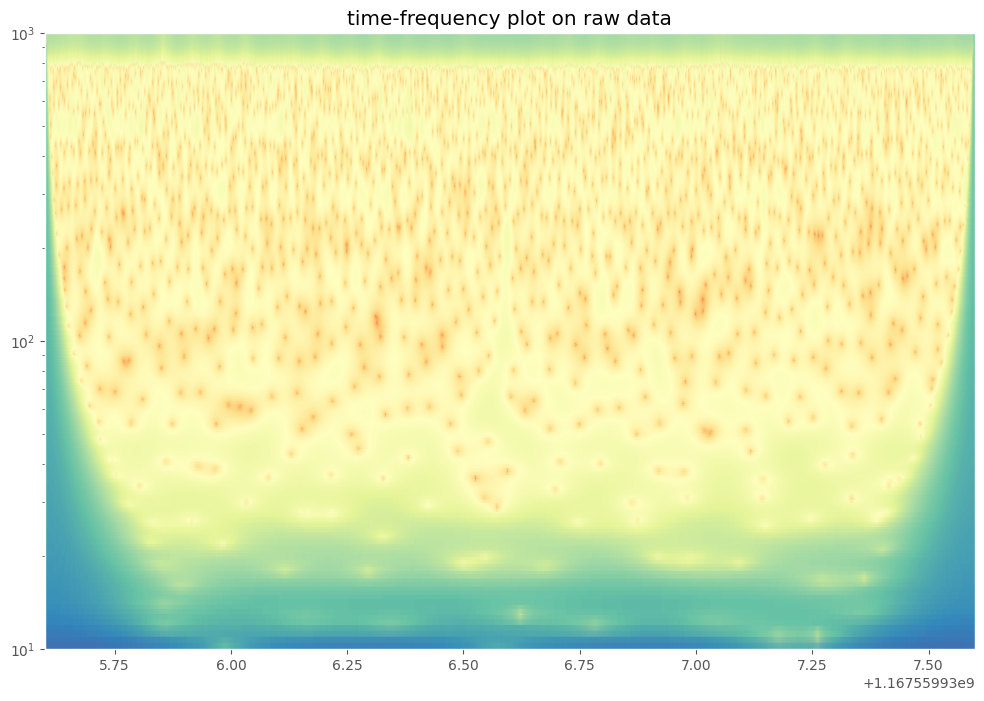

In [21]:
prepareImage_gw(x,y,par.sampling,"time-frequency plot on raw data")

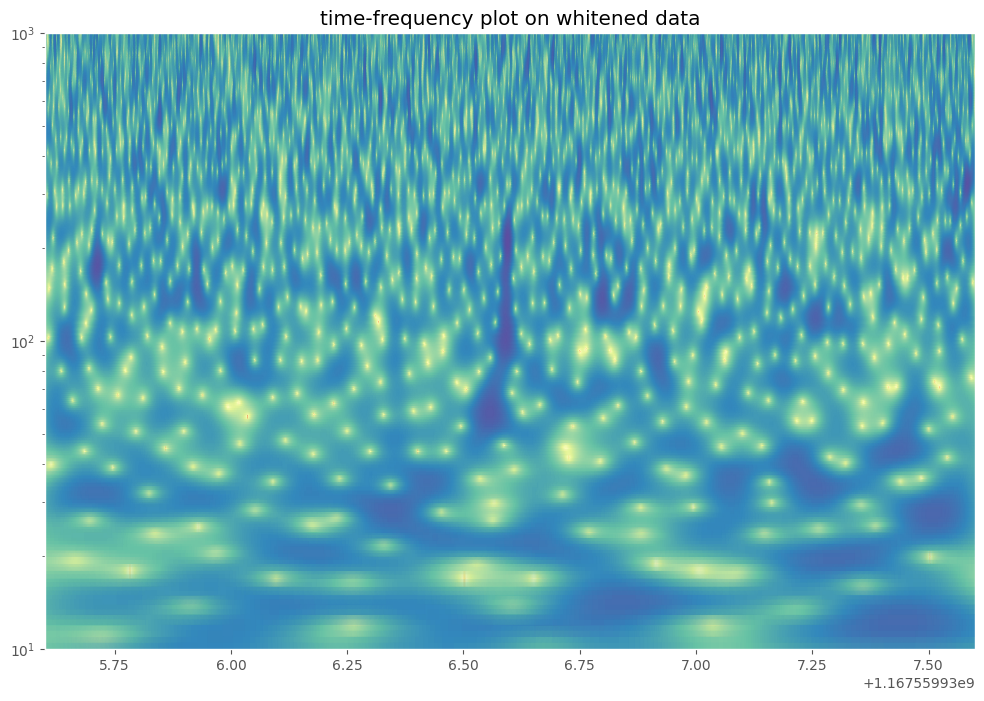

In [23]:
prepareImage_gw(x,yw,par.sampling,"time-frequency plot on whitened data")

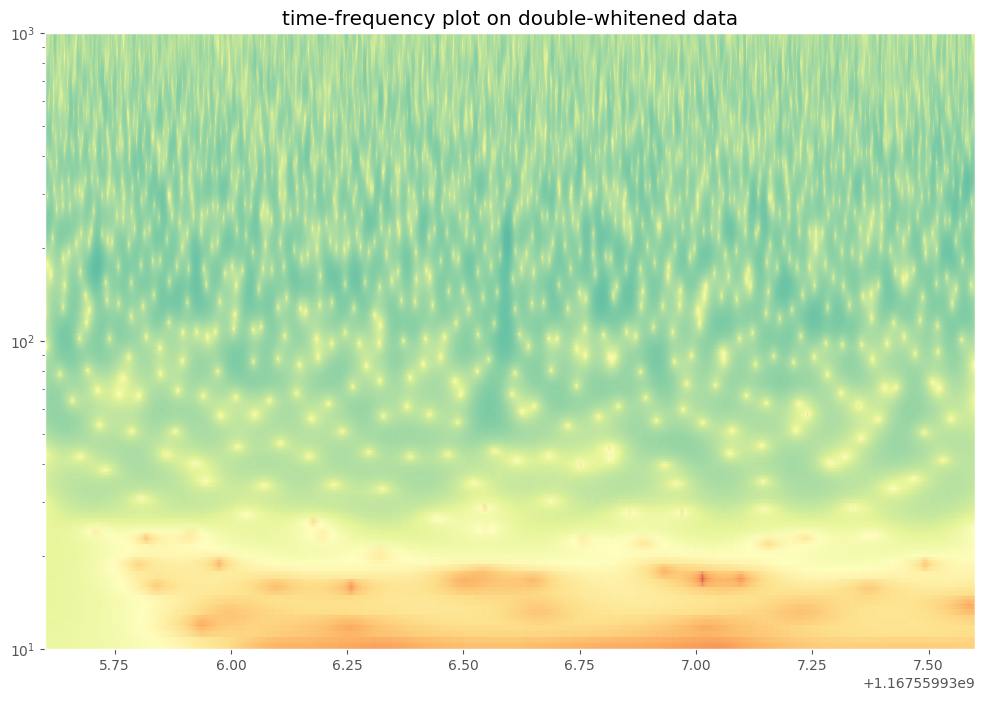

In [24]:
prepareImage_gw(x,yww,par.sampling,"time-frequency plot on double-whitened data")

In [25]:
datasize=data.GetSize()
yr=np.zeros(data.GetSize())
sigma=whiten.GetSigma()

wt = WaveletTransform.BsplineC309
WT = WaveletTransform(datasize, wt)
t =WaveletThreshold.dohonojohnston
wavthres = WaveletThreshold(datasize, 1, sigma);
 
WT.Forward(dataw);
wavthres(dataw, t);
WT.Inverse(dataw);
for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    yr[i]=dataw.GetY(0,i)


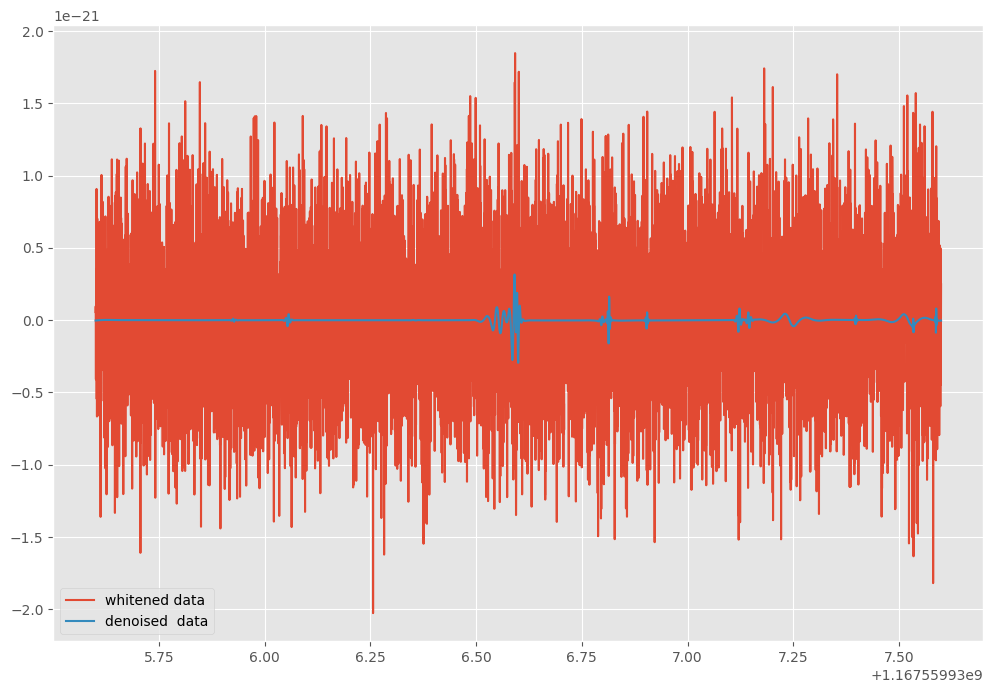

In [26]:


fig, ax = plt.subplots()

ax.plot(x, yw,  label='whitened data')
ax.plot(x, yr, label='denoised  data')

ax.legend()
plt.show()

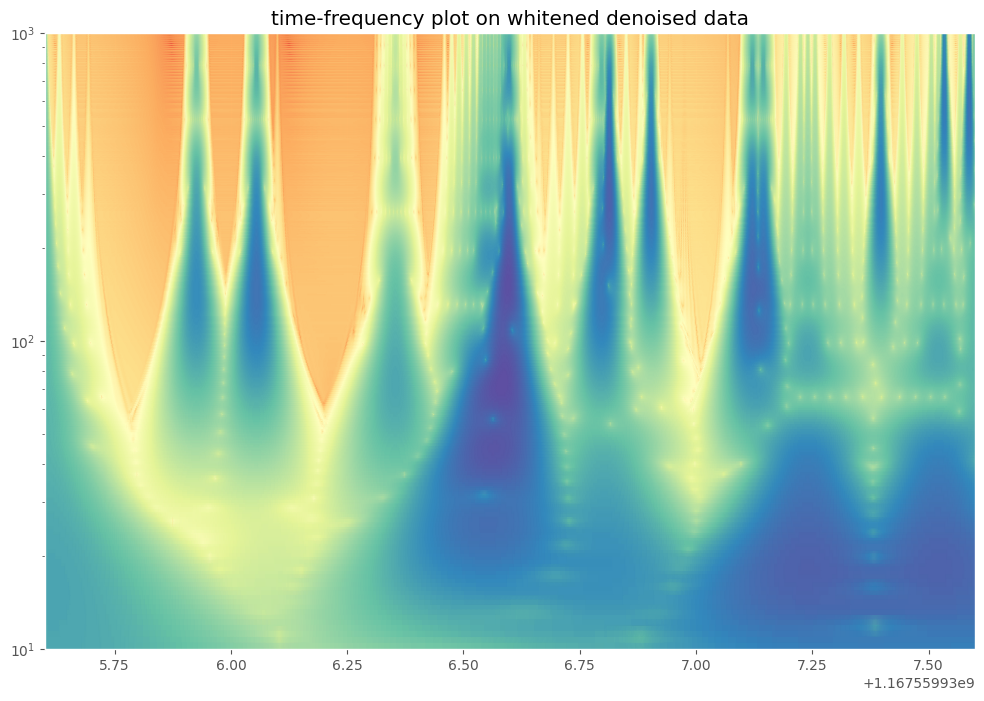

In [27]:
prepareImage_gw(x,yr,par.sampling,"time-frequency plot on whitened denoised data")

In [28]:
datasize=data.GetSize()
yr=np.zeros(data.GetSize())
sigma=whiten.GetSigma()

wt = WaveletTransform.BsplineC309
WT = WaveletTransform(datasize, wt)
t =WaveletThreshold.dohonojohnston
wavthres = WaveletThreshold(datasize, 1, sigma);
 
WT.Forward(dataww);
wavthres(dataww, t);
WT.Inverse(dataww);
for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    yr[i]=dataww.GetY(0,i)

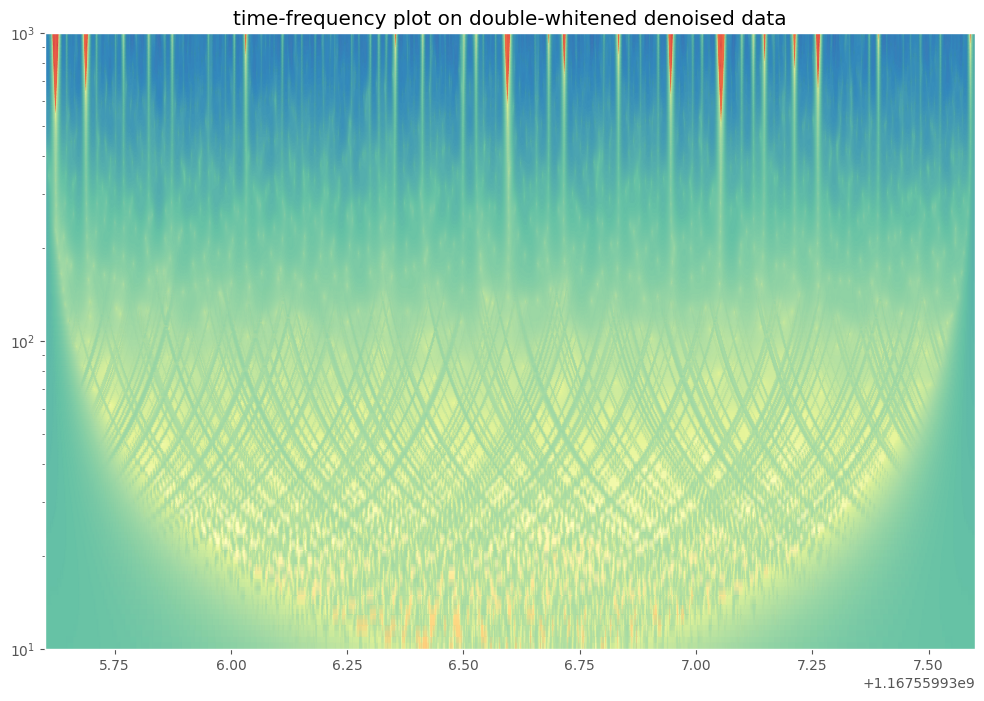

In [29]:
prepareImage_gw(x,yr,par.sampling,"time-frequency plot on double-whitened denoised data")

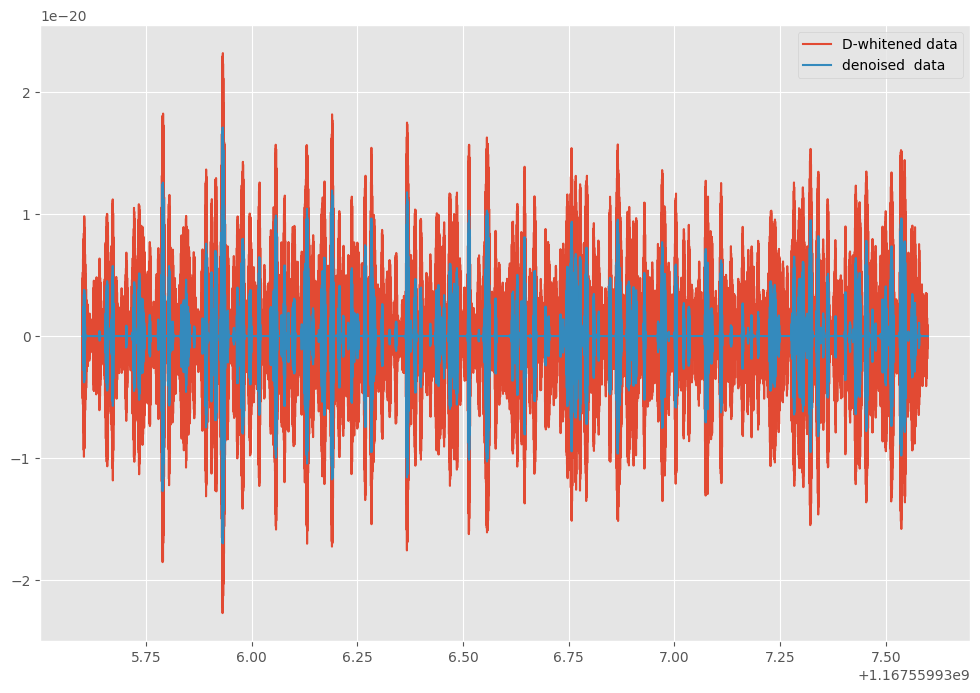

In [30]:
 
fig, ax = plt.subplots()
ax.plot(x,yww, label='D-whitened data')

ax.plot(x,yr, label='denoised  data')

ax.legend()
plt.show()